In [4]:
using DifferentialEquations
using Plots

Consider the simple reaction:

\begin{align}
    A &\longrightarrow B\\
\end{align}

The reaction is elementary, and B acts as a solvent for A and the transition state. We will consider it in a few different solvent environments. 

In [14]:
function batch(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, K10, V = PAR

    NA   = u[:,1]
    NB   = u[:,2]

    NT     = NA + NB
    
    XA   = NA./NT
    XB   = NB./NT
    
    #For A in B
    A12A = MAR[1]
    
    #For B in A
    A12B = MAR[2]
    
    #For Transition State 1 in B
    A12TS1 = MAR[3]

    gammaA  = exp.(XB.^2*A12A)
    gammaB  = exp.(XA.^2*A12B)
    gammaTS1 = exp.(XB.^2*A12TS1)

    z1 = 1/K10*gammaB./gammaA.*XB./XA

    r1 = k10*gammaA./gammaTS1.*XA.*(1 .- z1).*NT/V
    
    RA  = -r1[1]
    RB  =  r1[1]
    
    du[1] = RA*V
    du[2] = RB*V
    return du, r1
end

batch (generic function with 1 method)

In [12]:
k10  = 1
K10  = 1
V    = 1

NA0  = 100
NB0  = 0.0

var0     = [NA0 NB0]
span     = (0.0, 25.0);

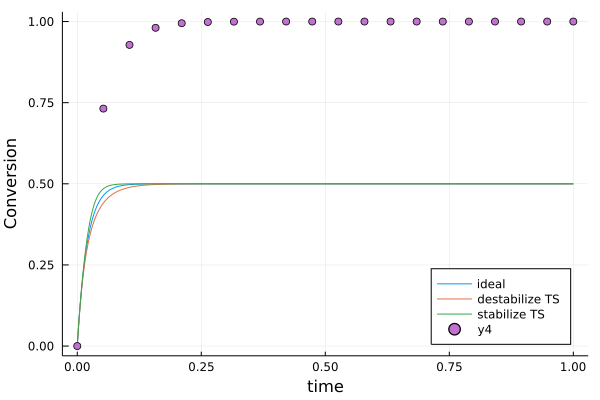

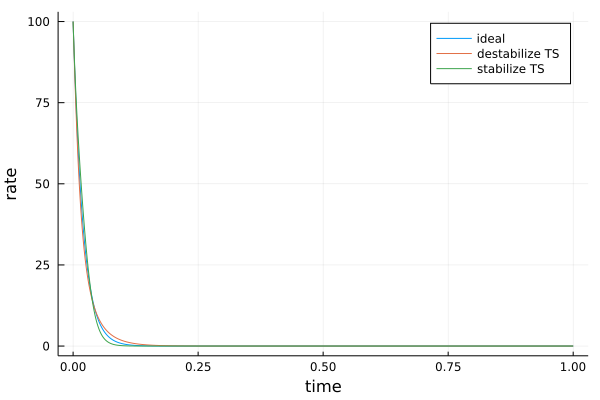

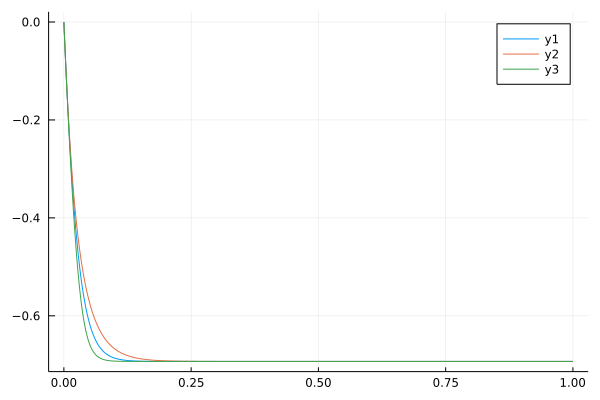

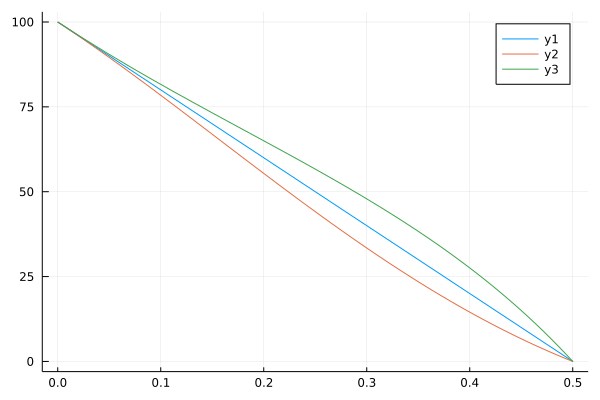

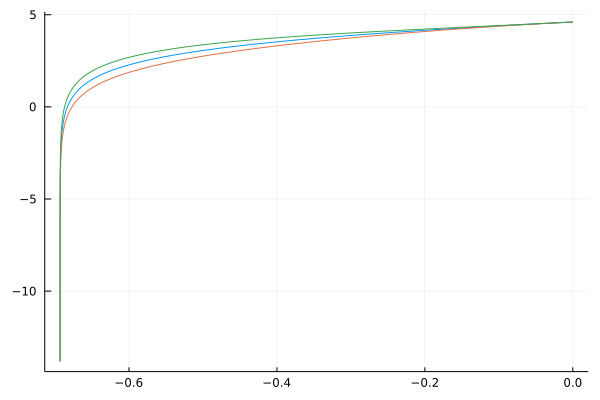

In [15]:
#Solvate transition state relative to reactants
MARSET1 = zeros(3,3)
MARSET1[:,1] = [0.0, 0.0, 0.0] #no solvation
MARSET1[:,2] = [0.0, 0.0, 2.0] #destabilize TS1
MARSET1[:,3] = [0.0, 0.0, -2.0] #stabilize TS1

tcoar  = range(0.0, stop = maximum(span), length = 20)
tfine  = range(0.0, stop = maximum(span), length = 1000)
Xout   = zeros(length(tfine), size(MARSET1, 2))
r1out  = zeros(length(tfine), size(MARSET1, 2))
NAout  = zeros(length(tfine), size(MARSET1, 2))
NBout  = zeros(length(tfine), size(MARSET1, 2))

for i = 1:size(MARSET1, 2)
    p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k10, K10, V])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob, Rodas5(), abstol = 1e-18, reltol = 1e-18)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB
    ext  = NB/NA0
    dut, rt1 = batch([0., 0.], [NA NB], p0, tfine)

    Xout[:,i]  = ext
    r1out[:,i] = rt1
    NAout[:,i] = NA
    NBout[:,i] = NB
end

Xout[Xout .>= 0.9999] .= 0.9999

plt1 = plot(tfine/maximum(tfine), Xout, xlabel  = "time", ylabel = "Conversion", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :bottomright)
plt1 =scatter!(plt1, tcoar/maximum(tcoar), 1 .- exp.(-k10*tcoar))
plt2 = plot(tfine/maximum(tfine), r1out, xlabel  = "time", ylabel = "rate", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)
plt3 = plot(tfine/maximum(tfine), log.(1 .- Xout))
plt4 = plot(Xout, r1out)
r1out[r1out .<= 0.000001] .= 0.000001
plt5 = plot(log.(1 .- Xout), log.(r1out), legend = nothing)
# plt2 = plot!(tfine[2:end]/maximum(tfine), r1out[2:end,:], labels = ["r1" nothing nothing])
# plt3 = plot(Xout, r2out, xlabel  = "extent", ylabel = "rate", labels = ["r1" nothing nothing], legend = :topright)
# # plt3 = plot!(e2out, r2out, labels = ["r2" nothing nothing])
# plt4 = plot(Xout, z1out, xlabel  = "extent", ylabel = "z", labels = ["z1" nothing nothing], legend = :topright)
# plt4 = plot!(Xout, z2out, labels = ["z2" nothing nothing])
# plt5 = plot(tfine/maximum(tfine), z1out, xlabel  = "time", ylabel = "z", labels = ["z1" nothing nothing], legend = :topright)
# plt5 = plot!(tfine/maximum(tfine), z2out, labels = ["z2" nothing nothing])

display(plt1)
display(plt2)
display(plt3)
display(plt4)
display(plt5)
# plot(tfine/maximum(tfine), cov)